## Titanic Dataset Overview

The Titanic dataset contains information about passengers aboard the Titanic, including survival status, demographics, and travel details. It has **891 rows** and **12 columns**.

### Data Dictionary

| Variable | Definition | Key/Notes |
|----------|------------|-----------|
| **PassengerId** | Unique identifier for each passenger | `int64` |
| **Survived** | Survival status | `0 = No, 1 = Yes` |
| **Pclass** | Ticket class | `1 = 1st (Upper), 2 = 2nd (Middle), 3 = 3rd (Lower)`<br>A proxy for socio-economic status (SES) |
| **Name** | Passenger's name | `object` |
| **Sex** | Sex | `male, female` |
| **Age** | Age in years | `float64`<br>• Age is fractional if less than 1<br>• Estimated ages are in the form xx.5 |
| **SibSp** | Number of siblings/spouses aboard | `int64`<br>• Sibling = brother, sister, stepbrother, stepsister<br>• Spouse = husband, wife (mistresses and fiancés were ignored) |
| **Parch** | Number of parents/children aboard | `int64`<br>• Parent = mother, father<br>• Child = daughter, son, stepdaughter, stepson<br>• Some children traveled only with a nanny (parch=0) |
| **Ticket** | Ticket number | `object` |
| **Fare** | Passenger fare | `float64` |
| **Cabin** | Cabin number | `object` |
| **Embarked** | Port of embarkation | `C = Cherbourg, Q = Queenstown, S = Southampton` |

### Dataset Characteristics
- **Total passengers**: 891 (sample of the actual 2,224 passengers and crew)
- **Missing values**: 
	- Age: 177 missing (714 non-null)
	- Cabin: 687 missing (204 non-null)
	- Embarked: 2 missing (889 non-null)
- **Target variable**: `Survived` (binary classification)
- **Key features**: Pclass, Sex, Age, SibSp, Parch, Fare, Embarked

The sinking of the RMS Titanic on April 15, 1912, during her maiden voyage is one of the most infamous maritime disasters in history. The "unsinkable" ship collided with an iceberg, resulting in the deaths of 1,502 out of 2,224 passengers and crew. The tragedy was exacerbated by insufficient lifeboats, leading to survival being influenced by factors beyond mere chance.

### The Analytical Challenge
This dataset presents an opportunity to build a predictive model that answers the fundamental question: **"What sorts of people were more likely to survive the Titanic disaster?"**

By analyzing passenger attributes such as:
- Socio-economic status (via Pclass)
- Gender and age demographics
- Family size (SibSp + Parch)
- Travel details (fare, embarkation port)

We can uncover patterns in survival likelihood and build models that predict survival outcomes based on passenger characteristics. This serves as a classic binary classification problem in machine learning, combining historical analysis with predictive modeling techniques.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Loading the Train Dataset from Kaggle 

In [2]:
train_url = "https://raw.githubusercontent.com/jhlopesalves/classic_workflows/refs/heads/main/supervised_learning/classification/titanic/data/train.csv"
train = pd.read_csv(train_url)

In [3]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train.isna().sum().sort_values(ascending=False)

,0
Cabin,687
Age,177
Embarked,2
PassengerId,0
Name,0
Pclass,0
Survived,0
Sex,0
Parch,0
SibSp,0


## Exploratory Data Analysis (EDA)

### Basic Plots 

In [6]:
sns.set_color_codes("bright")

In [7]:
train_plot = train.copy()
train_plot["Pclass"] = train_plot["Pclass"].map({1: "1st (Uppper)", 2: "2nd (Middle)", 3: "3rd (Lower)"})
train_plot["Embarked"] = train_plot["Embarked"].map({"C": "Cherbourg", "Q": "Queenstown", "S": "Southampton"})
train_plot["CabinCode"] = train_plot["Cabin"].str[0]
train_plot["CabinMissing"] = np.where(train_plot["CabinCode"].isna(), "Missing", "Non-missing")

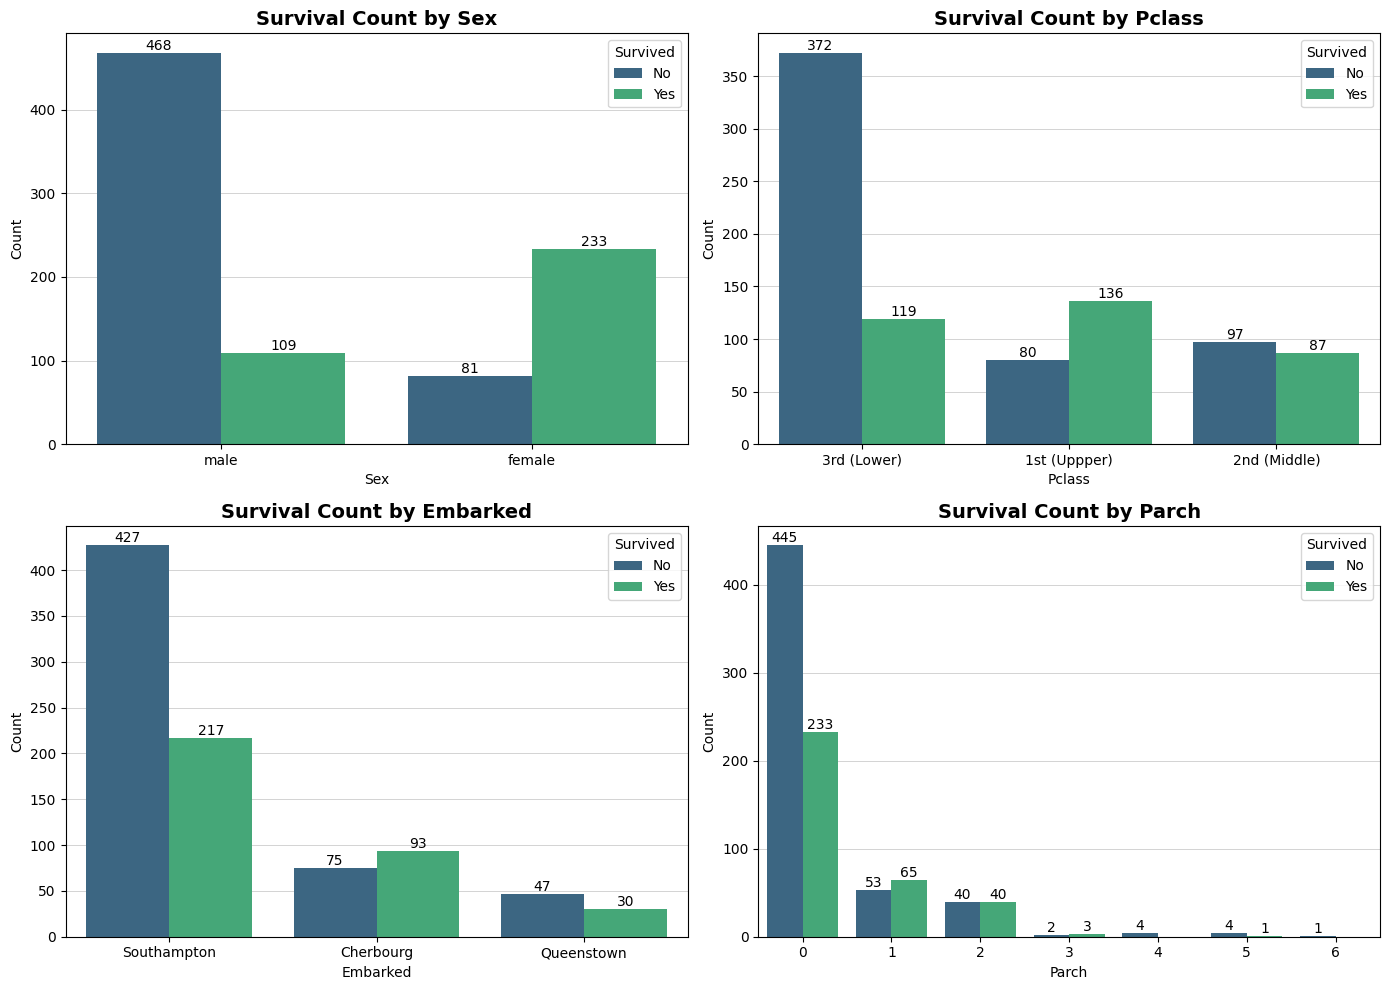

In [8]:
cols_interest = ["Sex", "Pclass", "Embarked", "Parch"]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(cols_interest):
		ax = axes[i]
		sns.countplot(data=train_plot, x=col, hue="Survived", palette="viridis", ax=ax)

		for container in ax.containers:
			ax.bar_label(container, fontsize=10)

		ax.set_title(f"Survival Count by {col}", fontsize=14, fontweight="bold")
		ax.set(xlabel=col.title(), ylabel="Count")  # noqa: E113
		ax.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
		ax.set_axisbelow(True)
		ax.legend(title="Survived", labels=["No", "Yes"])

plt.tight_layout()
plt.show()

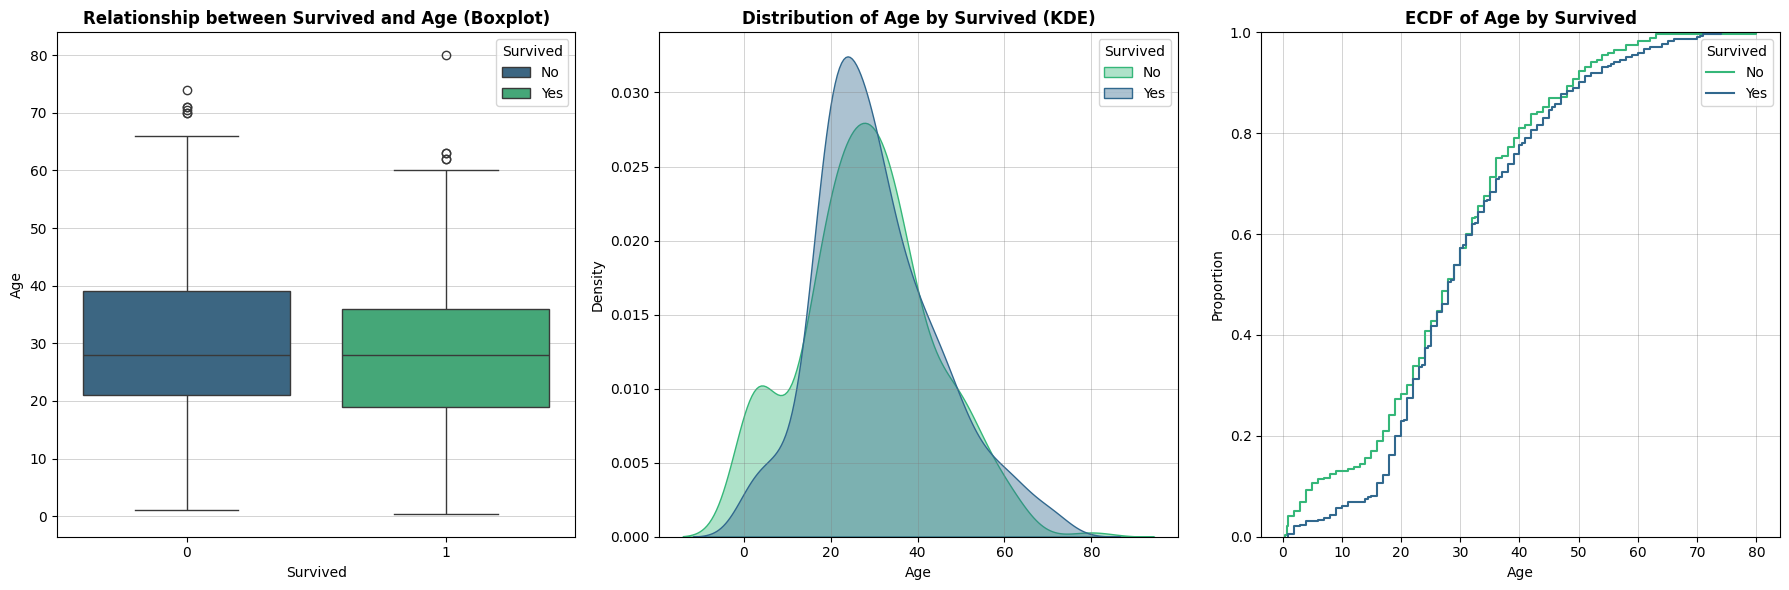

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(18, 6))


sns.boxplot(data=train_plot, x="Survived", y="Age", hue="Survived", palette="viridis", legend=True, ax=ax1)
ax1.set(xlabel="Survived", ylabel="Age")
ax1.set_title("Relationship between Survived and Age (Boxplot)", fontsize=12, fontweight="bold")
ax1.grid(True, axis="y", linewidth=0.6, alpha=0.4, color="grey")
ax1.legend(title="Survived", labels=["No", "Yes"])

sns.kdeplot(data=train_plot, x="Age", hue="Survived", palette="viridis", fill=True, common_norm=False, alpha=0.4, legend=True, ax=ax2)
ax2.set(xlabel="Age", ylabel="Density")
ax2.set_title("Distribution of Age by Survived (KDE)", fontsize=12, fontweight="bold")
ax2.grid(True, linewidth=0.6, alpha=0.4, color="grey")
ax2.legend(title="Survived", labels=["No", "Yes"])

sns.ecdfplot(data=train_plot, x="Age", hue="Survived", palette="viridis", legend=True, ax=ax3)
ax3.set(xlabel="Age", ylabel="Proportion")
ax3.set_title("ECDF of Age by Survived", fontsize=12, fontweight="bold")
ax3.grid(True, linewidth=0.6, alpha=0.4, color="grey")
ax3.legend(title="Survived", labels=["No", "Yes"])

plt.tight_layout()
plt.show()

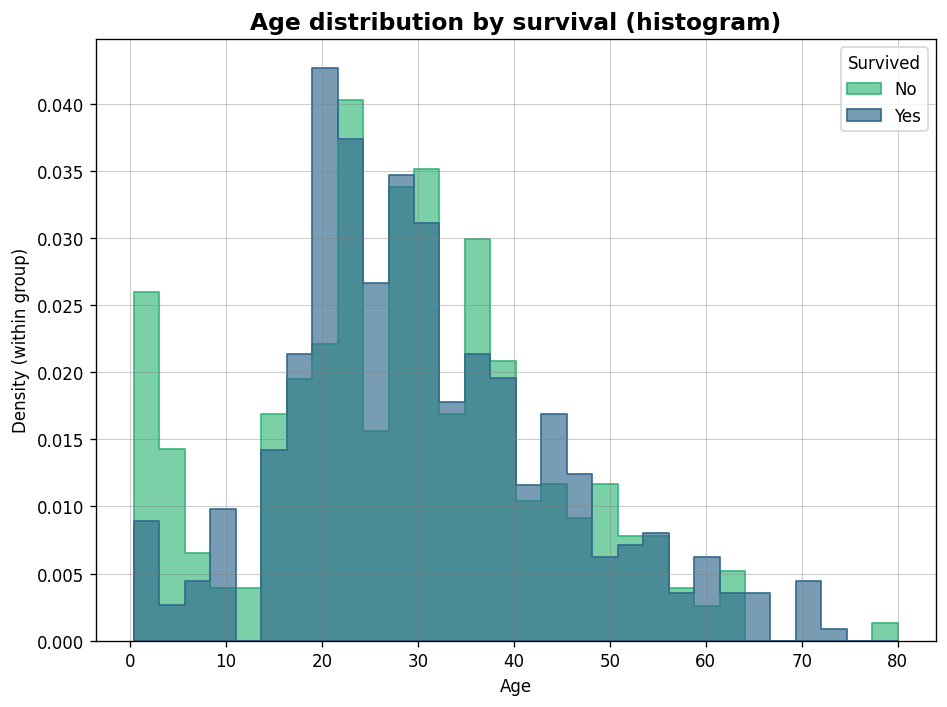

In [10]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=120)

sns.histplot(
    data=train_plot,
    x="Age",
    hue="Survived",
	palette="viridis",
    bins=30,
    stat="density",
    common_norm=False,
    element="step",
    alpha=0.65,
    ax=ax,
)

ax.set_title("Age distribution by survival (histogram)", fontsize=14, fontweight="bold")
ax.set(xlabel="Age", ylabel="Density (within group)")
ax.grid(True, linewidth=0.6, alpha=0.4, color="grey")
ax.legend(title="Survived", labels=["No", "Yes"])
plt.tight_layout()
plt.show()


In [12]:
train_plot.groupby("CabinCode")["Survived"].count()

,Survived
CabinCode,
A,15
B,47
C,59
D,33
E,32
F,13
G,4
T,1


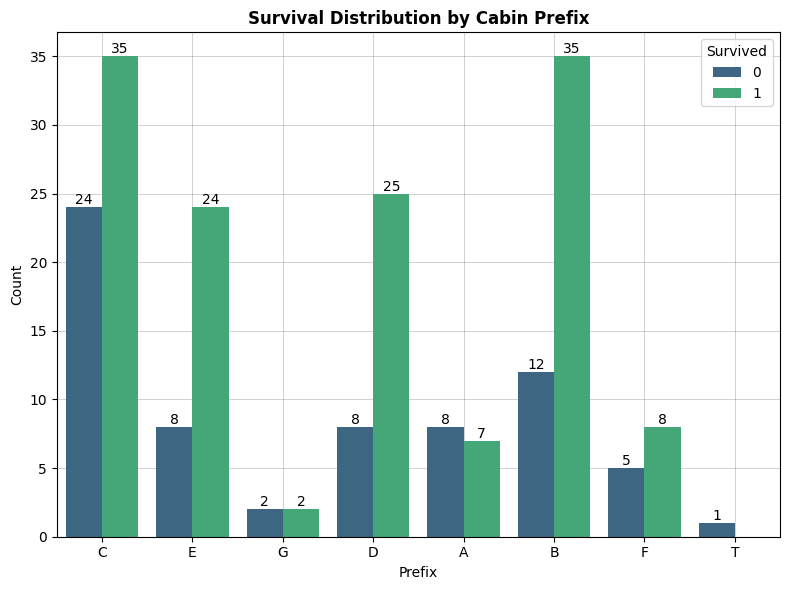

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.countplot(data=train_plot, x="CabinCode", hue="Survived", palette="viridis", ax=ax)

ax.set_title("Survival Distribution by Cabin Prefix", fontsize=12, fontweight="bold")
ax.set(xlabel="Prefix", ylabel="Count")
ax.grid(True, alpha=0.5, linewidth=0.5, color="grey")
ax.set_axisbelow(True)
for container in ax.containers:
	ax.bar_label(container, fontsize=10)

plt.tight_layout()
plt.show()

### Investigating Missing Values from 'Cabin' Column

In [14]:
cabin_missing = (train_plot[train_plot["CabinMissing"] == "Missing"])
cabin_not_missing = (train_plot[train_plot["CabinMissing"] == "Non-missing"])

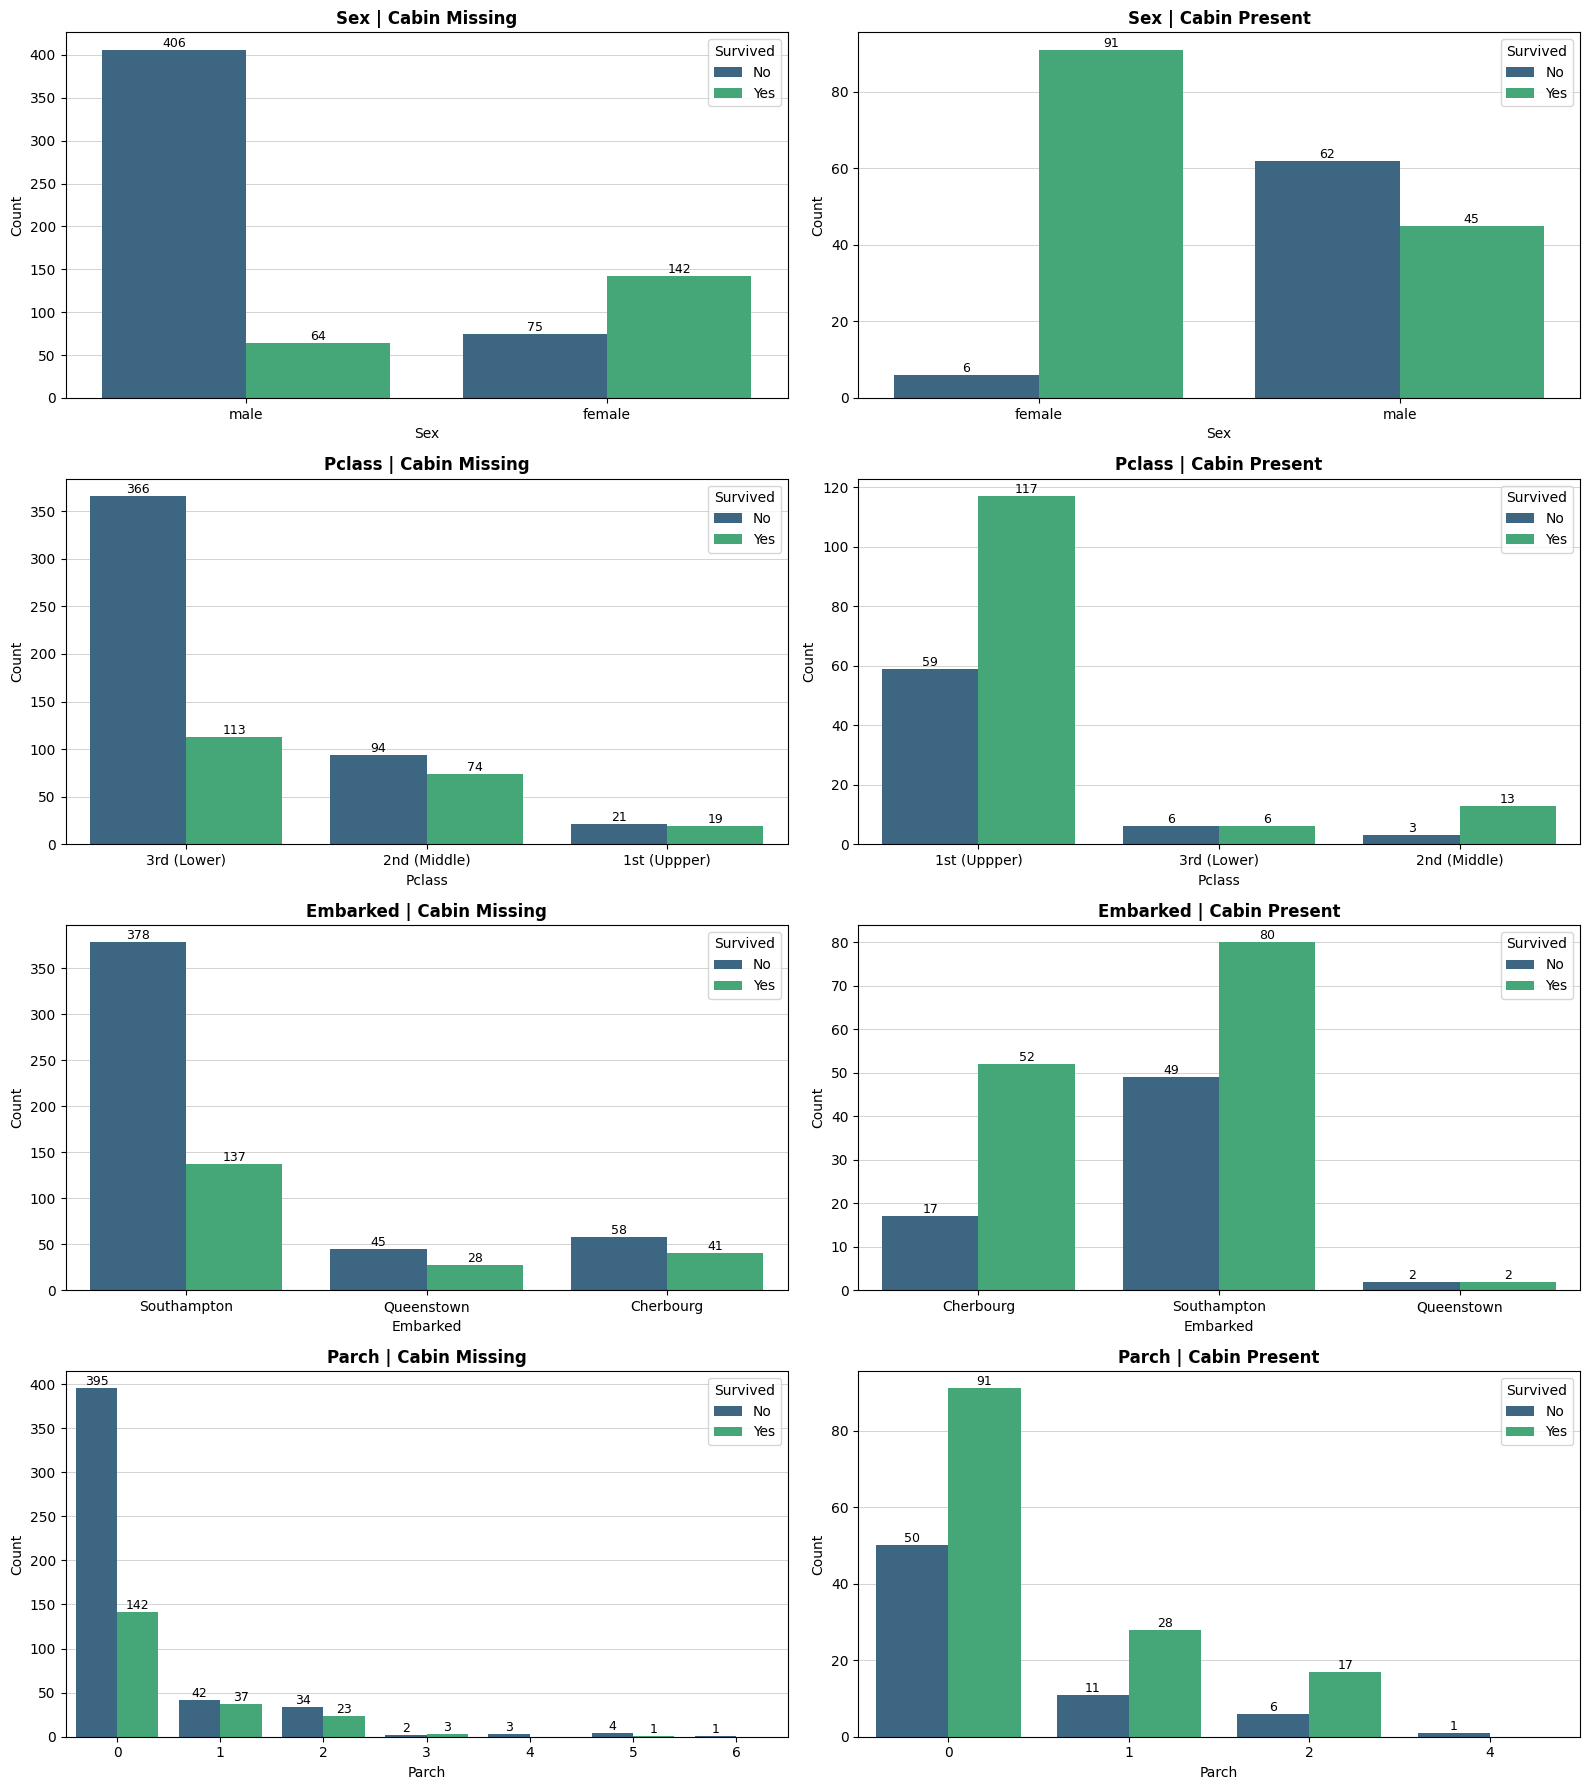

In [21]:
cols_interest = ["Sex", "Pclass", "Embarked", "Parch"]
fig, axes = plt.subplots(nrows=len(cols_interest), ncols=2, figsize=(16, 18))

for i, col in enumerate(cols_interest):
    # Left column: cabin missing
    ax_missing = axes[i, 0]
    sns.countplot(
        data=cabin_missing, 
        x=col, 
        hue="Survived", 
        palette="viridis", 
        ax=ax_missing
    )
    ax_missing.set_title(f"{col} | Cabin Missing", fontsize=12, fontweight="bold")
    ax_missing.set(xlabel=col.title(), ylabel="Count")
    ax_missing.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
    ax_missing.set_axisbelow(True)
    ax_missing.legend(title="Survived", labels=["No", "Yes"])
    
    for container in ax_missing.containers:
        ax_missing.bar_label(container, fontsize=9)
    
    # Right column: cabin present
    ax_present = axes[i, 1]
    sns.countplot(
        data=cabin_not_missing, 
        x=col, 
        hue="Survived", 
        palette="viridis", 
        ax=ax_present
    )
    ax_present.set_title(f"{col} | Cabin Present", fontsize=12, fontweight="bold")
    ax_present.set(xlabel=col.title(), ylabel="Count")
    ax_present.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
    ax_present.set_axisbelow(True)
    ax_present.legend(title="Survived", labels=["No", "Yes"])
    
    for container in ax_present.containers:
        ax_present.bar_label(container, fontsize=9)

plt.tight_layout()
plt.show()

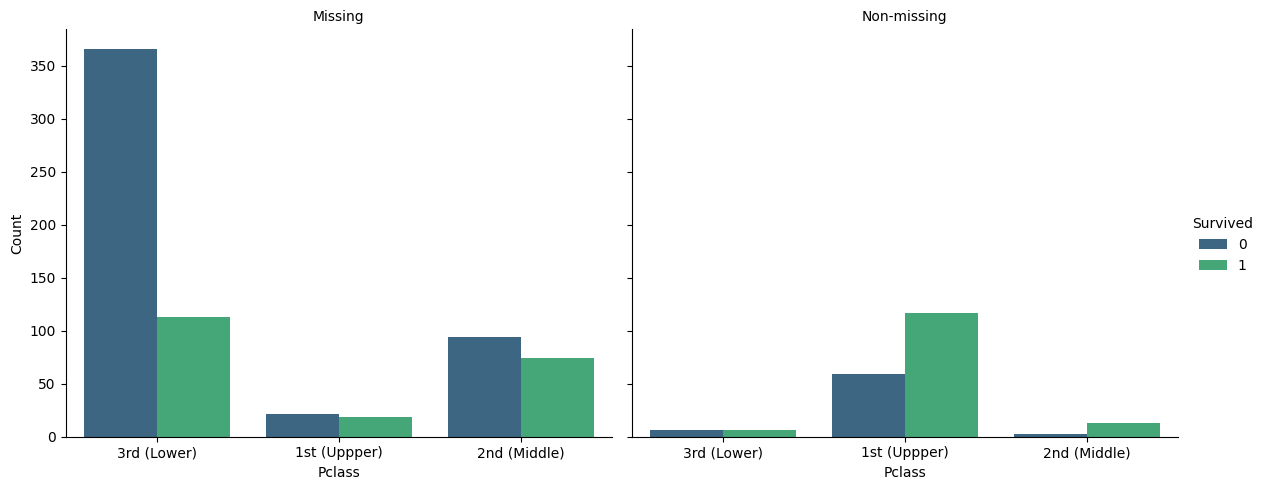

In [22]:
# For a single feature, say Pclass:
g = sns.catplot(
    data=train_plot,
    x="Pclass",
    hue="Survived",
    col="CabinMissing",  # <- this creates the side-by-side
    kind="count",
    palette="viridis",
    height=5,
    aspect=1.2
)
g.set_titles("{col_name}")
g.set_axis_labels("Pclass", "Count")
plt.show()